ID: 230118_A_Bulk-P3D2, sPV-SV: 0.068, Act-Est: 0.32
ID: 230119_A_Bulk-P3D2-10h-double, sPV-SV: -0.001, Act-Est: 0.25
ID: 230121_A_BulkPD5.1, sPV-SV: 0.039, Act-Est: 0.20
ID: 230124_A_Gset0.2-Bulk, sPV-SV: 0.013, Act-Est: 0.05
ID: 230128_A_0.1mmh-48hrs, sPV-SV: 0.027, Act-Est: 0.09
ID: 230130_A_0.8mmh-about6hrs, sPV-SV: 0.276, Act-Est: 0.36
ID: 230131_A_0.3growth, sPV-SV: 0.045, Act-Est: 0.04
ID: 230202_A_bulk0.4, sPV-SV: 0.009, Act-Est: 0.06
ID: 230204_A_0.5, sPV-SV: 0.028, Act-Est: 0.60
ID: 230205_A_0.6, sPV-SV: -0.018, Act-Est: 0.02
ID: 230214_A_0.4No.2, sPV-SV: 0.039, Act-Est: 0.13
ID: 230218_A_0.2mm50hr, sPV-SV: -0.028, Act-Est: 0.13
ID: 230220_A_0.3mm-hr, sPV-SV: -0.009, Act-Est: 0.59
ID: 230223_A_0.5No.2, sPV-SV: 0.074, Act-Est: 0.25
ID: 230308_A_0.2, sPV-SV: 0.052, Act-Est: 0.29
ID: 230323_A_0.5, sPV-SV: 0.134, Act-Est: 0.50
ID: 230325_A_0.6No2, sPV-SV: 0.123, Act-Est: 0.43
ID: 230326_A_0.1gr48hrapprox, sPV-SV: 0.076, Act-Est: 0.28
ID: 230328_A_0.2grbulk, sPV-SV: 0.143, Act-Est

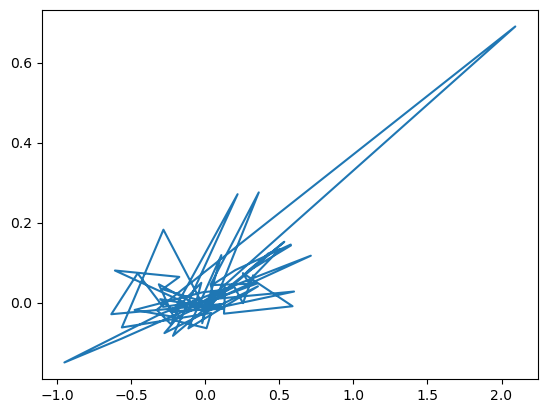

In [3]:
import pandas as pd
import glob
import os
import openpyxl
import matplotlib.pyplot as plt

dir_path = "../Data/FCG-excel"
files = glob.glob(f'{dir_path}/*.xlsx')
files.sort()

X, Y = [], []

for file in files:
   
    if not 'FALSE' in file:
        try:
            # glab the data
            df = pd.read_excel(file, sheet_name ='Data')
            
            # Read the second and third sheet
            wb = openpyxl.load_workbook(file)
            ws_P = wb["Parameters"]
            ws_I = wb["Information"]

            # ID
            ID = os.path.basename(file)[:-5]

            # SV
            SV = ws_P['I6'].value # Set growth rate (mm/h)

            # sPV calculation
            Smth_G = df['Smth_G (mm/h)'].to_list()
            last_G = Smth_G[-2169:] #cut the last 3 hour
            sPV = sum(last_G)/len(last_G) # average growth rate at the last 3 hours (mm/h)

            # Error
            gap = sPV - SV

            # Predicted Evaporation
            infusion = df['Inf-rate (mL/h)'].to_list()[-1]
            e_t = df['e(t)'].to_list()[-1]
            dedt = df['de(t)/dt'].to_list()[-1]

            Kp = ws_P['I8'].value
            Kd = ws_P['I10'].value
            
            try:
                int_e = df['int e'].to_list()[-1]
                Ki = ws_P['I9'].value
                Est_evap = infusion - (Kp*e_t + Ki*int_e + Kd*dedt) # mL/h
            except:
                Est_evap = infusion - (Kp*e_t + Kd*dedt) # mL/h
                
            Est_evap = Est_evap * 0.944 # g/h
            
            # Actual evap
            Act_evap = ws_I['I6'].value
            
            # Evaporation error
            Error_evap = Act_evap - Est_evap
            
            X.append(Error_evap)
            Y.append(gap)
            
            print(f'ID: {ID}, sPV-SV: {gap:.3f}, Act-Est: {Error_evap:.2f}')
            
        except Exception as e:
            print(e)

plt.plot(X,Y)

0.198331989399433 0.025316381208575968
0.5500739188343656
76
Correlation: 0.7416696831031759


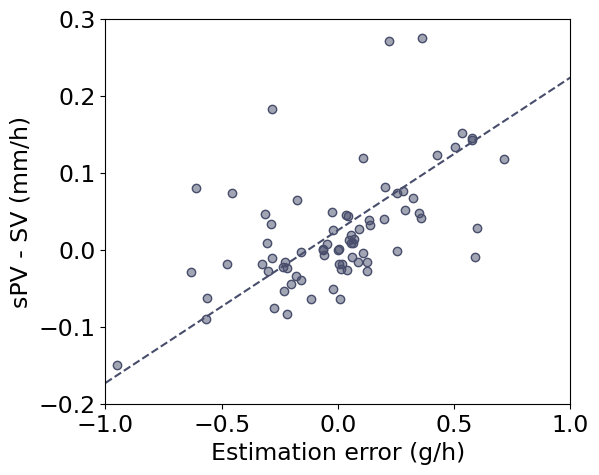

In [4]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# plot
plt.rcParams["font.size"] = 17
fig = plt.figure(figsize=(6,5))
color = "#474D6B" # dark blue

plt.scatter(X,Y,color=f'{color}80', edgecolor = color)
plt.xlabel('Estimation error (g/h)')
plt.ylabel('sPV - SV (mm/h)')
plt.xlim(-1,1)
plt.ylim(-0.2,0.3)

slope, intercept = np.polyfit(X,Y,1)
x_fit = [-1,1]
y_fit = [n*slope + intercept for n in x_fit]

plt.plot(x_fit, y_fit, linestyle = 'dashed', color = color)
print(slope, intercept)

y_fit = [n*slope + intercept for n in X]
print(r2_score(Y, y_fit))
print(len(Y))

correlation, _ = pearsonr(np.array(X), np.array(Y))

print("Correlation:", correlation)

figsavepath = "../Plots"
plt.savefig(f'{figsavepath}/FigureS9.svg', dpi=1200, bbox_inches='tight', transparent=True)